In [1]:
#导入包
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['figure.figsize'] = 15, 6
import pandas as pd
import statsmodels.api as sm
import matplotlib
%matplotlib inline
import datetime

In [59]:
#导入数据
data = pd.read_csv('AirPassengers.csv')
dates=list(data['Month'])
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
data['Month']=dates
data = data.set_index('Month')
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

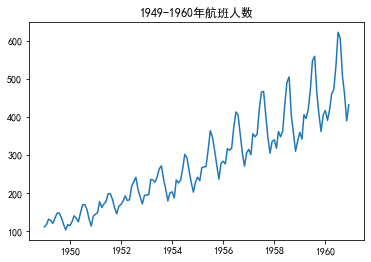

In [60]:
#绘制
plt.plot(data)
plt.title('1949-1960年航班人数')
plt.savefig('1949-1960年航班人数')

图中发现有上升趋势，且有季节性
同时可以使用seasonal_decompose函数进行分析，可以看出季节性非常明显

<Figure size 432x288 with 0 Axes>

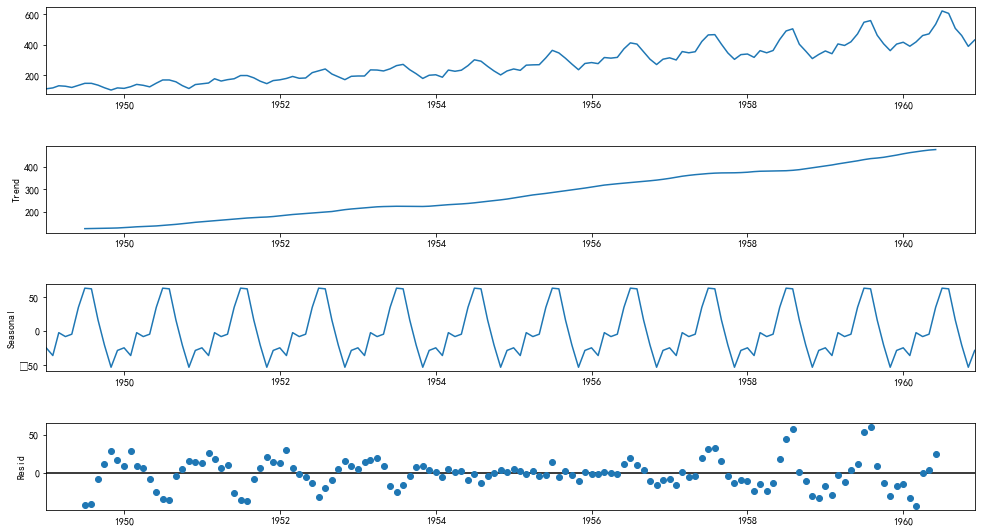

In [67]:
decomposition = sm.tsa.seasonal_decompose(data,model='additive')  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
plt.savefig('分解趋势图')

In [36]:
#可以分别获得趋势、季节性和随机性
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid

# 平稳化

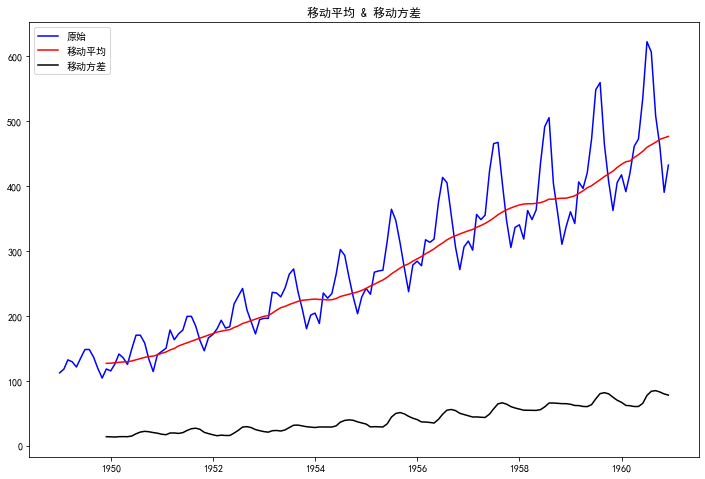

迪克富勒检验结果:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [70]:
from statsmodels.tsa.stattools import adfuller   #Dickey-Fuller test
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='原始')
    mean = plt.plot(rolmean, color='red', label='移动平均')
    std = plt.plot(rolstd, color='black', label = '移动方差')
    plt.legend(loc='best')
    plt.title('移动平均 & 移动方差')
    plt.savefig('移动平均 & 移动方差')
    plt.show()
    

    #Perform Dickey-Fuller test:
    print('迪克富勒检验结果:')
    dftest = adfuller(timeseries, autolag='AIC')  #autolag : {‘AIC’, ‘BIC’, ‘t-stat’, None}
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(data)

可以看出时间序列不平稳，因此我们要将时间序列转为平稳序列
Deflation by CPI

Logarithmic

First Difference

Seasonal Difference

Seasonal Adjustment

首先用1阶差分消除序列的整体趋势

In [78]:
data_log=np.log(data)

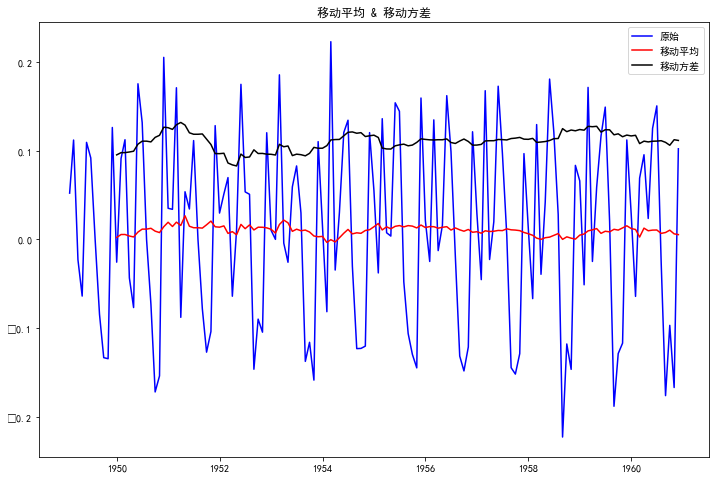

迪克富勒检验结果:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [80]:
log_diff1 = data_log.diff(1)
test_stationarity(log_diff1.dropna(inplace=False))

接下来在1阶差分的基础上使用季节性差分

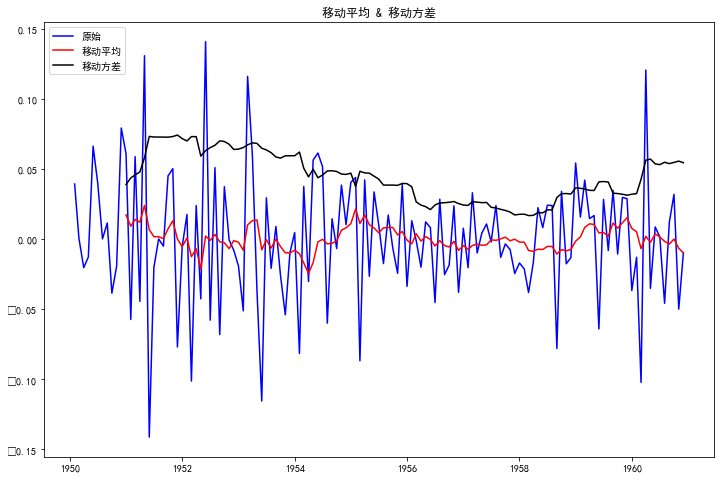

迪克富勒检验结果:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [81]:
sea_diff = log_diff1 - log_diff1.shift(12)  
test_stationarity(sea_diff.dropna(inplace=False))

In [84]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(sea_diff.dropna(), lags = [6,12],boxpierce=True)

(array([23.27094078, 51.47284007]),
 array([7.10630704e-04, 7.68546569e-07]),
 array([22.63192596, 47.99887549]),
 array([9.29608852e-04, 3.12707671e-06]))

# ACF PACF 寻找最优p和q

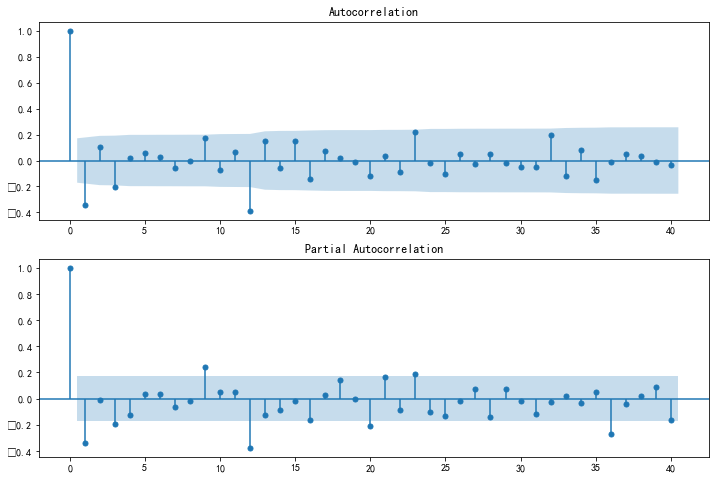

In [89]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sea_diff.iloc[13:], lags=40, ax=ax1) #从13开始是因为做季节性差分时window是12
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sea_diff.iloc[13:], lags=40, ax=ax2)
plt.savefig('ACF & PACF')

ARIMA(p, d, q) × (P, D, Q)S 

In [ ]:
(0, 1, 1)x(1, 1, 1, 12)

In [101]:
mod = sm.tsa.statespace.SARIMAX(data, trend='n', order=(0,1,1), seasonal_order=(1,1,1,12),enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -456.160
Date:                            Fri, 18 Jun 2021   AIC                            920.319
Time:                                    02:56:38   BIC                            931.368
Sample:                                01-01-1949   HQIC                           924.805
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3351      0.076     -4.403      0.000      -0.484      -0.186
ar.S.L12      -0.5597      0.285   

In [90]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [91]:
warnings.filterwarnings("ignore")

In [92]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2044.4329486427587
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1887.355624655896
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1315.9211929474204
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1156.291490150854
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1118.6259190717344
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1107.2562043240036
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1109.2437994445115
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1033.6172166730355
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1846.078937757177
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1567.9916312319474
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1196.998361439989
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1072.1382984044342
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1071.0026810381928
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1049.5801417205844
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1059.5112223290455
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:985.3346478033052
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1405.0006612949667
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1194.71300109796

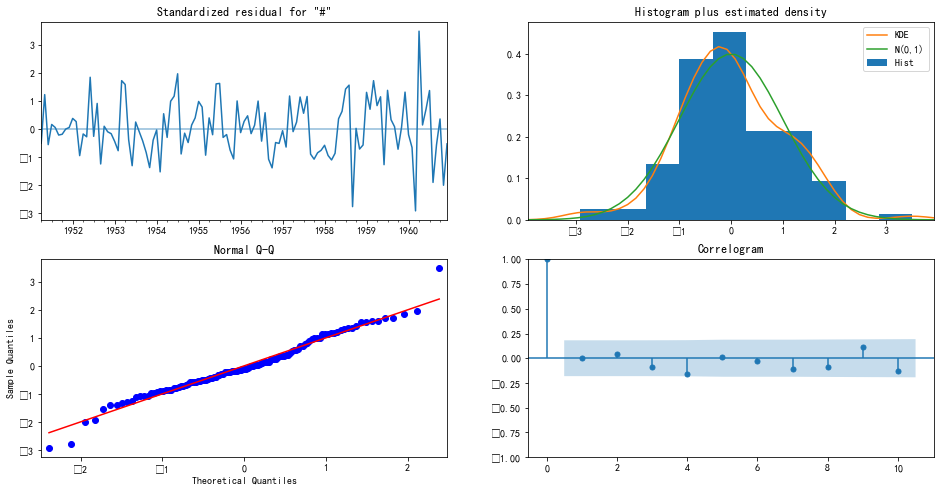

In [100]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('模型诊断图')
plt.show()

# 预测

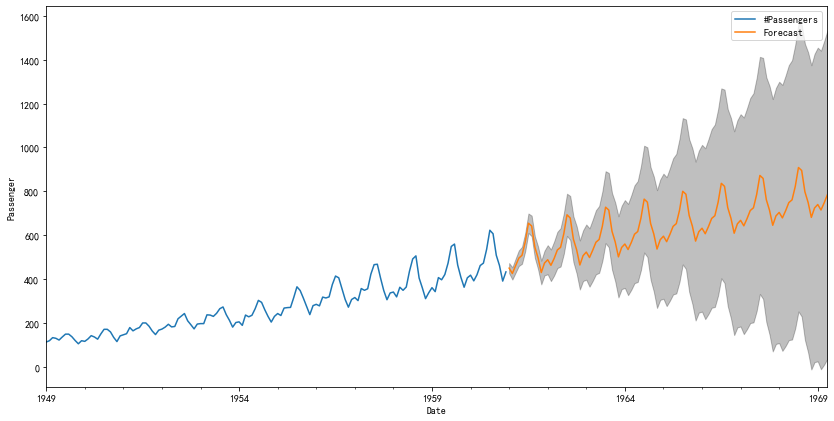

In [124]:
pred_uc = results.get_forecast(steps=100) 
pred_ci = pred_uc.conf_int()
ax = data.plot(label='observed', figsize=(14, 7)) 
pred_uc.predicted_mean.plot(ax=ax, label='Forecast') 
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='k', alpha=.25) 
ax.set_xlabel('Date') 
ax.set_ylabel('Passenger')
plt.legend() 
plt.savefig('对未来数据进行预测')
plt.show()

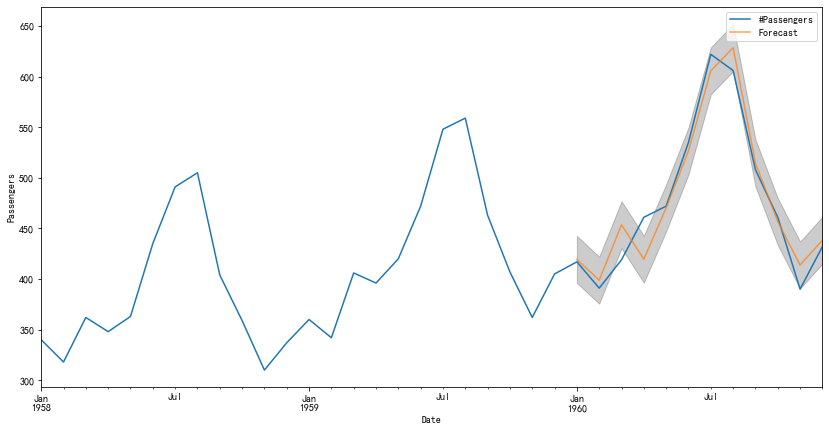

In [116]:
pred = results.get_prediction(start=pd.to_datetime('1960-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = data['1958':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.savefig('有训练集的预测')
plt.legend()

In [120]:
y_forecasted = pred.predicted_mean
y_truth = data['1960-01-01':]['#Passengers']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 374.73


In [121]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 19.36
